In [1]:
# This notebook is derived from Qiskit and includes modifications by qBraid.
#
# (C) Copyright IBM 2020.
# (C) Copyright qBraid 2023.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

# qBraid-SDK Braket on IonQ device Tutorial: Quantum Teleportation 

Per usual, install the qBraid SDK environment on Lab, and use the qBraid CLI to enable [Quantum Jobs](https://docs.qbraid.com/en/latest/lab/quantumjobs.html)

In [2]:
!qbraid jobs enable qbraid_sdk

Successfully enabled qBraid Quantum Jobs in the qbraid_sdk environment.
Every AWS job you run will now be submitted through the qBraid API, so no access keys/tokens are necessary. 

To disable, run: `qbraid jobs disable qbraid_sdk`


You can check that the `jobs` keyword next to the qBraid SDK environment is now green."

In [3]:
!qbraid envs list

# installed environments:
#
default                  jobs  /opt/.qbraid/environments/qbraid_000000
aws_braket               jobs  /home/jovyan/.qbraid/environments/aws_braket_kwx6dl
qiskit                   jobs  /home/jovyan/.qbraid/environments/qiskit_i5o7if
qiskit_gpu                     /home/jovyan/.qbraid/environments/qiskit_gpu_tyt64d
tensorflow                     /home/jovyan/.qbraid/environments/tensorflow_uorhf3
qbraid_sdk               jobs  /home/jovyan/.qbraid/environments/qbraid_sdk_9j9sjy
pyquil                         /home/jovyan/.qbraid/environments/pyquil_i4l3hx
mitiq                          /home/jovyan/.qbraid/environments/mitiq_7rq6q3



It's important to import the qBraid SDK only *after* you have enabled quantum jobs.

In [4]:
import qbraid

qbraid.__version__

'0.4.5'

# Creating the Circuit

In [5]:
from qiskit import QuantumCircuit

The code for this circuit was taken from IBMs Quantum Teleportation tutorial. Check out their [tutorial](https://www.youtube.com/watch?v=mMwovHK2NrE&t) for a more in depth explanation. The idea is that we want to transport a qubit state from one person (Alice) to another (Bob). We utlizie an entangled Bell state to do so.

In [6]:
qiskit_circuit = QuantumCircuit(3, 3)
qiskit_circuit.x(0)
# Controlled Hadamard gates are not part of the quantum gates supported by the Harmony device
qiskit_circuit.ch(0, 1)
qiskit_circuit.ch(0, 1)
# ----
qiskit_circuit.barrier()
qiskit_circuit.h(1)
qiskit_circuit.cx(1, 2)
qiskit_circuit.barrier()
qiskit_circuit.cx(0, 1)
qiskit_circuit.h(0)
qiskit_circuit.barrier()
qiskit_circuit.measure([0, 1], [0, 1])
qiskit_circuit.barrier()
qiskit_circuit.cx(1, 2)
qiskit_circuit.cz(0, 2)
qiskit_circuit.measure([2], [2])

In [7]:
from qbraid.interface import circuit_drawer

circuit_drawer(qiskit_circuit)

┌───┐           ░            ░      ┌───┐ ░ ┌─┐    ░            
q_0: ┤ X ├──■────■───░────────────░───■──┤ H ├─░─┤M├────░───────■────
     └───┘┌─┴─┐┌─┴─┐ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░       │    
q_1: ─────┤ H ├┤ H ├─░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░───■───┼────
          └───┘└───┘ ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░ ┌─┴─┐ │ ┌─┐
q_2: ────────────────░──────┤ X ├─░────────────░──╫──╫──░─┤ X ├─■─┤M├
                     ░      └───┘ ░            ░  ║  ║  ░ └───┘   └╥┘
c: 3/═════════════════════════════════════════════╩══╩═════════════╩═
                                                  0  1             2

Notice that we've added two controlled-Hadamard gates: applying two controlled-Hadamards back to back is equivalent to the identity gate. Theoretically, this is the same circuit, however controlled-Hadamard gates are not supported on the IonQ computer. We will see how we can leverage qBraid's capabilities to still run this circuit on IonQ's computer.

We can observe the supported gate set with the following:

In [8]:
from braket.aws import AwsDevice

aws_device = AwsDevice("arn:aws:braket:us-east-1::device/qpu/ionq/Harmony")

# show supported quantum operations (supported gates for this device)
device_operations = aws_device.properties.dict()["action"][
    "braket.ir.openqasm.program"
]["supportedOperations"]
print(f"Quantum Gates supported by {aws_device.name}:\n {device_operations}\n")

Quantum Gates supported by Harmony:
 ['x', 'y', 'z', 'rx', 'ry', 'rz', 'h', 'cnot', 's', 'si', 't', 'ti', 'v', 'vi', 'xx', 'yy', 'zz', 'swap']



We initially programmed this circuit in qiskit, but we want to test braket circuit capabilties on the IonQ computer. Thus, we can use qBraid's circuit wrapper to convert the circuit to braket:

In [9]:
from qbraid import circuit_wrapper

In [10]:
qbraid_circuit = circuit_wrapper(qiskit_circuit)
braket_circuit = qbraid_circuit.transpile("braket")

circuit_drawer(braket_circuit)

T  : |0|1|2|3|4|5|6|7|
                      
q0 : -X-C-C-----C-H-C-
        | |     |   | 
q1 : ---H-H-H-C-X-C-|-
              |   | | 
q2 : ---------X---X-Z-

T  : |0|1|2|3|4|5|6|7|


# Attemping to Run the Circuit without qBraid

In [11]:
try:
    job = aws_device.run(braket_circuit, shots=100)
except Exception as err:
    print(err)

An error occurred (ValidationException) when calling the CreateQuantumTask operation (reached max retries: 4): [line 5] arbitrary unitary gates are not supported on the requested device


## Running on an IonQ Device via qBraid

Let's check which devices (specifically IonQ ones) are online, and also find their device IDs:

In [12]:
from qbraid import get_devices

In [13]:
get_devices(filters={"provider": "IonQ"})

Let's check how many credits we have left:

In [14]:
!qbraid jobs get-credits

You have 955.60 remaining qBraid credits.


In this tutorial we'll use IonQ's Harmony computer. Now we can use qBraid's [device wrapper](https://docs.qbraid.com/en/latest/sdk/devices.html#device-wrapper) to run a job on an IonQ device. The device wrapper adds a layer of abstraction, allowing us to run a braket circuit on an IonQ quantum computer. 

In [15]:
from qbraid import device_wrapper

In [16]:
ibmq_sim = device_wrapper("ibm_q_qasm_simulator")
ionq_device = device_wrapper("aws_ionq_harmony")

# # can also use vendor deviceArn / backend ID directly
# ibmq_sim = device_wrapper("ibmq_qasm_simulator")
# ionq_device = device_wrapper("arn:aws:braket:us-east-1::device/qpu/ionq/Harmony")

Feel free to change the number of shots to reduce the number of qBraid credits:

In [17]:
# running qiskit circuit on AWS device
ionq_job = ionq_device.run(qiskit_circuit, shots=100)
ionq_job.status()

<JobStatus.QUEUED: 'job is queued'>

In [20]:
# comparing against simulator result run on IBM
ibm_job = ibmq_sim.run(qiskit_circuit, shots=100)
ibm_job.status()

<JobStatus.COMPLETED: 'job has successfully run'>

In [21]:
simulator_result = ibm_job.result()
simulator_counts = simulator_result.measurement_counts()
print(simulator_counts)

{'100': 27, '101': 29, '110': 27, '111': 17}


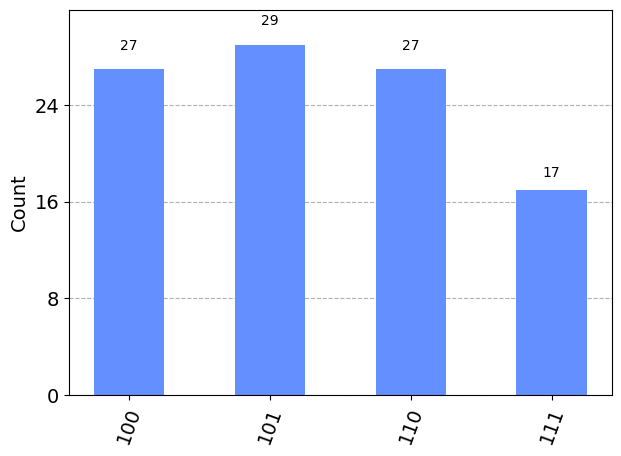

In [22]:
simulator_result.plot_counts()

In [ ]:
from qbraid import get_jobs, job_wrapper

In [ ]:
get_jobs()

In [ ]:
ionq_job = job_wrapper("")

In [ ]:
ionq_result = ionq_job.result()
ionq_counts = result.measurement_counts()
print(counts)

In [ ]:
ionq_result.plot_counts()

We see that we've correctly teleported the state, since ``c2`` (the leading qubit) is far more likely to be 1, and we teleported the $|1\rangle$ state!